Training LSTM model...
Evaluating LSTM model...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
LSTM - MAE: 7.68, RMSE: 11.19, MAPE: 0.02%, Training Time: 6.56 seconds
------------------------------
Training GRU model...
Evaluating GRU model...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
GRU - MAE: 8.10, RMSE: 12.09, MAPE: 0.02%, Training Time: 7.16 seconds
------------------------------
Training RNN model...
Evaluating RNN model...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RNN - MAE: 8.01, RMSE: 11.81, MAPE: 0.02%, Training Time: 5.06 seconds
------------------------------
Training TCN model...
Evaluating TCN model...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
TCN - MAE: 7.52, RMSE: 11.38, MAPE: 0.02%, Training Time: 16.64 seconds
------------------------------
Training TKAN model...
Evaluating TKAN model...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
TKAN - MAE: 7.42, RMSE: 11.20, MAPE: 0.02%, Training Time: 14.21 seconds
------------------------------
Training TKAT model...
Evaluating TKAT model...
5/5 ━━━━━━━━

,MAE,RMSE,MAPE,Training Time (s)
lstm,7.684182,11.191743,0.016051,6.557146
gru,8.102846,12.088039,0.016994,7.161902
rnn,8.013604,11.808981,0.016749,5.058887
tcn,7.517196,11.377745,0.015665,16.635978
tkan,7.424533,11.204988,0.015549,14.209116
tkat,7.192076,12.038074,0.015092,132.697997


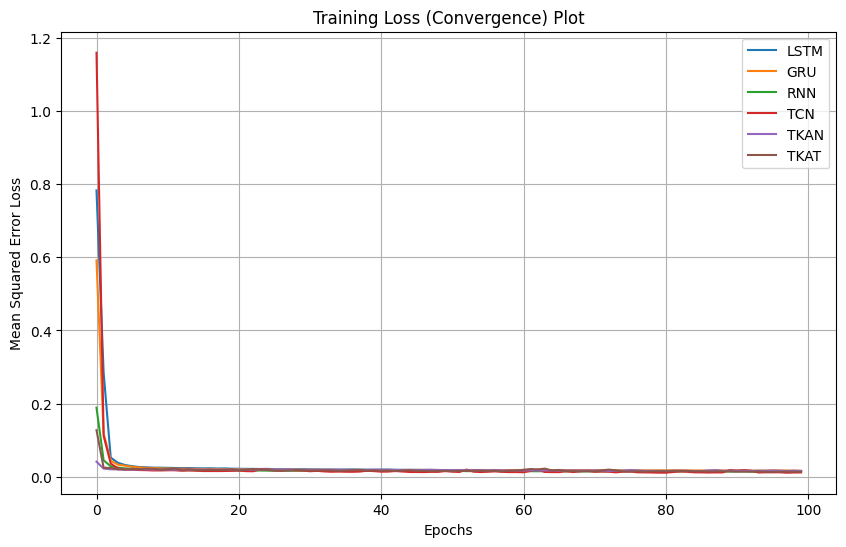

In [ ]:
import os
BACKEND = 'jax'  # You can use any backend here
os.environ['KERAS_BACKEND'] = BACKEND

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, SimpleRNN, Layer, Input
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tkan import TKAN
from tcn import TCN
import time
from tkat import TKAT
import jax
import jax.numpy as jnp

keras.utils.set_random_seed(1)

# Load the dataset
df = pd.read_csv('air_quality_data_feb_mar_2025.csv')

# Preprocess the timestamp
df['datetime'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['datetime'])
df = df.drop(columns=['timestamp'])

# Function to calculate AQI
def calculate_aqi(pm25, pm10, co, no2, o3):
    """
    Calculates the Air Quality Index (AQI) based on Indian standards.

    Args:
        pm25: PM2.5 concentration (µg/m3)
        pm10: PM10 concentration (µg/m3)
        co:  CO concentration (mg/m3)
        no2: NO2 concentration (µg/m3)
        o3:  O3 concentration (µg/m3)

    Returns:
        The calculated AQI value.  Returns -1 for invalid input.
    """
    def calculate_sub_index(c, breakpoints, aqi_values):
        """
        Calculates the sub-index for a given pollutant concentration.

        Args:
            c: Pollutant concentration
            breakpoints: Concentration breakpoints for AQI categories
            aqi_values: AQI values corresponding to the breakpoints

        Returns:
            The sub-index for the pollutant.
        """
        if c <= breakpoints[0]:
            return aqi_values[0]
        elif c > breakpoints[-1]:
            return aqi_values[-1]
        else:
            for i in range(len(breakpoints) - 1):
                if breakpoints[i] < c <= breakpoints[i + 1]:
                    l_o = breakpoints[i]
                    l_i = aqi_values[i]
                    h_i = aqi_values[i + 1]
                    h_o = breakpoints[i + 1]
                    return ((h_i - l_i) / (h_o - l_o)) * (c - l_o) + l_i
        return -1

    # AQI calculation for each pollutant
    pm25_aqi = calculate_sub_index(pm25, [0, 30, 60, 90, 120, 250, 350], [0, 50, 100, 150, 200, 300, 400]) if pm25 is not None else 0
    pm10_aqi = calculate_sub_index(pm10, [0, 50, 100, 250, 350, 430, 800], [0, 50, 100, 200, 300, 400, 500]) if pm10 is not None else 0
    co_aqi = calculate_sub_index(co, [0, 1.0, 2.0, 10, 17, 34, 400], [0, 50, 100, 200, 300, 400, 500]) if co is not None else 0
    no2_aqi = calculate_sub_index(no2, [0, 40, 80, 180, 280, 400, 1200], [0, 50, 100, 200, 300, 400, 500]) if no2 is not None else 0
    o3_aqi = calculate_sub_index(o3, [0, 50, 100, 168, 208, 748, 1000], [0, 50, 100, 200, 300, 400, 500]) if o3 is not None else 0

    return max(pm25_aqi, pm10_aqi, co_aqi, no2_aqi, o3_aqi)

# Calculate AQI and add it as a new column
df['aqi'] = df.apply(lambda row: calculate_aqi(row['pm25'], row['pm10'], row['co'], row['no2'], row['o3']), axis=1)

# Handle missing values using interpolation
for col in ['pm25', 'pm10', 'co', 'no2', 'o3', 'aqi']:
    df[col] = df[col].interpolate()

# Create lagged features
def create_lagged_features(df, target_column, lags):
    for lag in lags:
        df[f'{target_column}_lag_{lag}'] = df[target_column].shift(lag)
    return df

df = create_lagged_features(df, 'aqi', [1, 3, 6, 12, 24])
df = df.dropna()  # Drop rows with NaN values introduced by lagging

# Prepare data for modeling
target_column = 'aqi'
features = ['pm25', 'pm10', 'co', 'no2', 'o3', 'aqi_lag_1', 'aqi_lag_3', 'aqi_lag_6', 'aqi_lag_12', 'aqi_lag_24']

# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(df) * 0.8)
df_train = df[:train_size].copy()
df_test = df[train_size:].copy()

# Scale features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(df_train[features])
features_test_scaled = scaler.transform(df_test[features])

# Scale target variable
target_scaler = MinMaxScaler()
target_scaled = target_scaler.fit_transform(df_train[[target_column]])
target_test_scaled = target_scaler.transform(df_test[[target_column]])  # scale the target test.

# Prepare data for RNN-based models with updated sequence length
timesteps = 1  # The actual sequence length you want for past observations
effective_timesteps = timesteps + 1  # Account for the extra step (n_ahead=1)
X_train = features_scaled[:len(features_scaled) - (len(features_scaled) % effective_timesteps)].reshape(
    -1, effective_timesteps, features_scaled.shape[1]
)
y_train = target_scaled[:len(X_train)]  # Adjust target to match the new shape
X_test = features_test_scaled[:len(features_test_scaled) - (len(features_test_scaled) % effective_timesteps)].reshape(
    -1, effective_timesteps, features_test_scaled.shape[1]
)
y_test = target_test_scaled[:len(X_test)]

def create_and_train_model(model_type, X_train, y_train, epochs=100, verbose=0):
    """
    Creates and trains a time series model.

    Args:
        model_type: The type of model to create ('lstm', 'gru', 'rnn', 'tcn', 'tkan', 'tkat').
        X_train: The training data.
        y_train: The training target.
        epochs: Number of training epochs.
        verbose: Verbosity mode (0 = silent, 1 = progress bar).

    Returns:
        The trained model and its training history.
    """
    if model_type in ['lstm', 'gru', 'rnn', 'tcn']:
        model = Sequential()
        if model_type == 'lstm':
            model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
            model.add(LSTM(50, activation='relu'))
        elif model_type == 'gru':
            model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
            model.add(GRU(50, activation='relu'))
        elif model_type == 'rnn':
            model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
            model.add(SimpleRNN(50, activation='relu'))
        elif model_type == 'tcn':
            model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
            model.add(TCN(nb_filters=50, kernel_size=2))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose)
        return model, history

    elif model_type == 'tkan':
        # TKAN Implementation
        input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))  # Define Input layer
        tkan_output = TKAN(
            units=64,  # Use a single integer for units
            dropout=0.1
        )(input_layer)
        output_layer = Dense(1)(tkan_output)  # Add Dense layer
        model = keras.Model(inputs=input_layer, outputs=output_layer)  # Define the model
        model.compile(optimizer='adam', loss='mean_squared_error')  # Compile the model
        history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose)  # Train the model
        return model, history

    elif model_type == 'tkat':
        # TKAT Implementation
        input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))  # Define Input layer
        tkat_output = TKAT(
            sequence_length=timesteps,  # Use the original sequence length
            num_unknow_features=X_train.shape[2],  # Number of observed features
            num_know_features=0,  # Number of known features
            num_embedding=64,
            num_hidden=64,
            num_heads=2,
            n_ahead=1,  # Explicitly set n_ahead to 1
        )(input_layer)
        output_layer = Dense(1)(tkat_output)  # Add Dense layer
        model = keras.Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer='adam', loss='mean_squared_error')
        history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose)
        return model, history
    else:
        raise ValueError(f"Invalid model type: {model_type}")

# Dictionary to store results
results = {}
model_types = ['lstm', 'gru', 'rnn', 'tcn', 'tkan', 'tkat']
histories = {}

for model_type in model_types:
    print(f"Training {model_type.upper()} model...")
    start_time = time.time()
    model, history = create_and_train_model(model_type, X_train, y_train, epochs=100, verbose=0)
    end_time = time.time()
    training_time = end_time - start_time
    histories[model_type] = history.history['loss']

    print(f"Evaluating {model_type.upper()} model...")
    predictions_scaled = model.predict(X_test)

    # Inverse transform predictions and actual values
    predictions = target_scaler.inverse_transform(predictions_scaled).flatten()  # Inverse transform and flatten
    actual_values = target_scaler.inverse_transform(y_test).flatten()  # Inverse transform and flatten

    # Calculate metrics
    mae = mean_absolute_error(actual_values, predictions)
    rmse = np.sqrt(mean_squared_error(actual_values, predictions))
    mape = mean_absolute_percentage_error(actual_values, predictions)

    # Store metrics and training time
    results[model_type] = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Training Time (s)': training_time
    }

    print(f"{model_type.upper()} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%, Training Time: {training_time:.2f} seconds")
    print("-" * 30)

# Create and display the results DataFrame
df_results = pd.DataFrame.from_dict(results, orient='index')
print("\nModel Evaluation Results:")
display(df_results)

# Plotting the training loss
plt.figure(figsize=(10, 6))
for model_type, loss_history in histories.items():
    plt.plot(loss_history, label=model_type.upper())
plt.title('Training Loss (Convergence) Plot')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Save the trained model
model.save('tkat_model.h5')

# Load the model for inference
from keras.models import load_model
model = load_model('tkat_model.h5', custom_objects={'TKAT': TKAT})

# Example: Dynamic inference
current_hour = 6  # Example: Current time is 6 AM
past_features = features_test_scaled[-current_hour:]  # Last 6 hours of data

# Pad with zeros if necessary
if past_features.shape[0] < current_hour:
    padding = np.zeros((current_hour - past_features.shape[0], features_scaled.shape[1]))
    past_features = np.vstack((padding, past_features))

# Add n_ahead padding for the model
n_ahead = 1
future_padding = np.zeros((n_ahead, features_scaled.shape[1]))
past_features = np.vstack((past_features, future_padding))

# Prepare input for the model
input_data = np.expand_dims(past_features, axis=0)  # Shape: (1, dynamic_timesteps + n_ahead, num_features)

# Predict using the model
predictions = model.predict(input_data)

ValueError: Inputs have incompatible shapes. Received shapes (1, 64) and (1, 128)